# Argovis explore vertical structure of ocean fields

This notebook contains some examples and is a work in progress: code will transition from here to other notebooks. Public consumers should focus on our educational notebooks, starting with [Intro to Argovis](https://github.com/argovis/demo_notebooks/blob/main/Intro_to_Argovis.ipynb).

In [1]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import dateutil

from Argovis_tasks_helpers import get_route, interpolate_profiles, grids_to_xarray, xarray_regional_mean

API_KEY='eaf7ca218b692a2e0ee0b3dc524697f43ad085e6'

/Users/dgiglio/opt/miniconda3/envs/argovis_demos/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
# API call showing collections available for each route

#### parameters the user needs to select
# user selects list of collections
collections = ['argo', 'grids/glodap',
              ]

# show list of variables available
for icollection in collections:
    try:
        print(avh.query(icollection+'/vocabulary', options={'parameter': 'data'}, verbose='true',apikey=API_KEY, apiroot=get_route(icollection)) )
    except:
        print(avh.query(icollection+'/vocabulary', verbose='true',apikey=API_KEY, apiroot=get_route(icollection)) )

# define name of variable of interest for each product (first show list of all variables available for each collection)
varname     = ['doxy', 'oxygen']
varname_qc  = [',1', '']
vartitle    = 'Oxygen, umol/kg'

# define name of the variable that includes levels for each collection
varname_levels = ['pressure','']

# variable             = 'temperature' # variable name in Argo profiles
# variable_gridded     = 'rg09_temperature' # variable name in glodap gridded product
# product_gridded      = 'rg09'
# variable_title       = 'Temperature, degC'

# variable             = 'salinity' # variable name in Argo profiles
# variable_gridded     = 'rg09_salinity' # variable name in glodap gridded product
# product_gridded      = 'rg09'
# variable_title       = 'Salinity, psu'

# levels for vertically integrated profiles
interp_levels        = list(range(10,2001))[0::20]

# in this example, we will use the 'box' selection (in the next cell),
# hence we indicate here the bottom/left and top/right vertices... 
# the other option is to search in a 'polygon' and indicate here the polygon
# vertices in a list
box_regions_list     = [
                        [[-180.5,45.5],[-170.5,50.5]],
                        [[-50,45],[-40,50]],
                        ]

regions_tags         = ['Pacific', 'Atlantic']

startDate            = '2021-01-01T00:00:00Z'
endDate              = '2021-12-31T00:00:00Z'

# box_regions_list     = [
#                         [[-78,45],[-10,50]],
#                         [[-180,45],[-127,50]],
#                         ]

https://argovis-api.colorado.edu/argo/vocabulary?parameter=data
['bbp470', 'bbp470_argoqc', 'bbp532', 'bbp532_argoqc', 'bbp700', 'bbp700_2', 'bbp700_2_argoqc', 'bbp700_argoqc', 'bisulfide', 'bisulfide_argoqc', 'cdom', 'cdom_argoqc', 'chla', 'chla_argoqc', 'chla_fluorescence', 'chla_fluorescence_argoqc', 'cndc', 'cndc_argoqc', 'cp660', 'cp660_argoqc', 'down_irradiance380', 'down_irradiance380_argoqc', 'down_irradiance412', 'down_irradiance412_argoqc', 'down_irradiance443', 'down_irradiance443_argoqc', 'down_irradiance490', 'down_irradiance490_argoqc', 'down_irradiance555', 'down_irradiance555_argoqc', 'down_irradiance665', 'down_irradiance665_argoqc', 'down_irradiance670', 'down_irradiance670_argoqc', 'downwelling_par', 'downwelling_par_argoqc', 'doxy', 'doxy2', 'doxy2_argoqc', 'doxy3', 'doxy3_argoqc', 'doxy_argoqc', 'nitrate', 'nitrate_argoqc', 'ph_in_situ_total', 'ph_in_situ_total_argoqc', 'pressure', 'pressure_argoqc', 'salinity', 'salinity_argoqc', 'salinity_sfile', 'salinity_sfile_

Thu Apr  4 01:35:18 MDT 2024
Region [[-180.5, 45.5], [-170.5, 50.5]] , argo collection
https://argovis-api.colorado.edu/argo?box=%5B%5B-180.5%2C+45.5%5D%2C+%5B-170.5%2C+50.5%5D%5D&data=doxy%2C1&startDate=2021-01-01T00%3A00%3A00.000000Z&endDate=2021-12-31T00%3A00%3A00.000000Z
Region [[-180.5, 45.5], [-170.5, 50.5]] , grids/glodap collection
For the glodap product, only the time mean is available
https://argovis-api.colorado.edu/grids/glodap?box=%5B%5B-180.5%2C+45.5%5D%2C+%5B-170.5%2C+50.5%5D%5D&data=oxygen&startDate=0001-01-01T00%3A00%3A00.000000Z&endDate=0001-01-02T00%3A00%3A00.000000Z
https://argovis-api.colorado.edu/grids/meta?id=glodapv2.2016b
Region [[-50, 45], [-40, 50]] , argo collection
https://argovis-api.colorado.edu/argo?box=%5B%5B-50%2C+45%5D%2C+%5B-40%2C+50%5D%5D&data=doxy%2C1&startDate=2021-01-01T00%3A00%3A00.000000Z&endDate=2021-12-31T00%3A00%3A00.000000Z
Region [[-50, 45], [-40, 50]] , grids/glodap collection
For the glodap product, only the time mean is available
https:

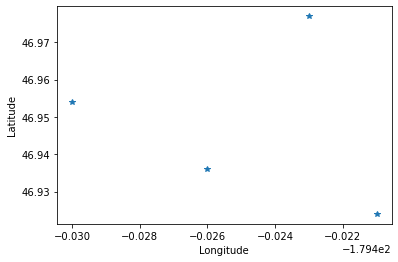

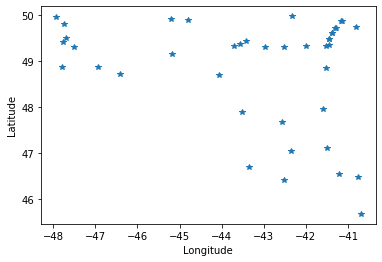

In [3]:
!date

regions_list_data_raw                   = []
regions_list_data_raw_xarray            = []
regions_list_data_vert_interp           = []
regions_list_data_horiz_ave             = []
regions_list_data_horiz_ave_levels      = []
regions_list_data_time                  = []

regions_list                            = []
regions_list_collections                = []
regions_list_tags                       = []
############ Get the data for each of the regions of interest, for each collection
for iiireg,ireg in enumerate(box_regions_list):
    for icol_ind,icollection in enumerate(collections):
        # print and store the region and collection for each item in the output lists
        print('Region '+str(ireg)+' , '+icollection+' collection')
        regions_list.append(ireg)
        regions_list_collections.append(icollection)
        regions_list_tags.append(regions_tags[iiireg])
        ###### get profiles in region using Argovis API (query based on qc if requested above for a collection)
        iparam = {
                'box': ireg,
                'data': varname[icol_ind]+varname_qc[icol_ind]
                } 
                # 'polygon': ireg,
        # the time range does not apply to glodap as only the time mean is available for glodap
        if 'glodap' in icollection:
            print('For the glodap product, only the time mean is available')
        else:
            iparam['startDate'] = startDate
            iparam['endDate']   = endDate
        api_output = avh.query(icollection, options=iparam, verbose='true',apikey=API_KEY, apiroot=get_route(icollection)) 

        ###### store data as is and interpolated
        if api_output: # len(api_output)>0
            ## interpolate profiles (if not from a grid)   
            interpolated_profiles      = []
            timestamps                 = []
            lons                       = []
            lats                       = []
            for i in list(range(0,len(api_output)-1)):
                if len(api_output[i]['data'][0]) > 1:
                    if 'grids' not in icollection:
                        interpolated_profiles.append(interpolate_profiles(profile=api_output[i],levels_varname=varname_levels[icol_ind],levels_new=interp_levels))
                    timestamps.append(dateutil.parser.isoparse(api_output[i]['timestamp'])) 
                    lons.append(api_output[i]['geolocation']['coordinates'][0])
                    lats.append(api_output[i]['geolocation']['coordinates'][1])
            
            if 'grids' not in icollection:
                # shape variable into something appropriate
                data = [x['data'] for x in interpolated_profiles]
                data = [[level[varname[icol_ind]] for level in x] for x in data]
                # store interpolated profiles
                regions_list_data_vert_interp.append(data)
                data = np.transpose(data)
                regions_list_data_horiz_ave.append(np.nanmean(data,1))
                regions_list_data_horiz_ave_levels.append(interp_levels)
                regions_list_data_raw_xarray.append([])
                regions_list_data_raw.append([x['data'] for x in api_output])
                ## quick plot of profiles in region
                plt.figure()
                plt.plot(lons,lats,marker='*',linestyle='none')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
            
            ## store raw profile info
            
            regions_list_data_time.append(timestamps)
            
            
            if 'grids' in icollection:
            
                grids_opt  = {
                            "id": api_output[0]['metadata'][0]
                            }
                grids_meta = avh.query('grids/meta', options=grids_opt, verbose='true',apikey=API_KEY, apiroot=get_route(icollection))

                xar = grids_to_xarray(api_output,grids_meta)
                # store data
                regions_list_data_vert_interp.append([]) # no need to interpolate for grids
                regions_list_data_raw_xarray.append(xar)
                xar_h_ave = xarray_regional_mean(xar)['data'].values.flatten()
                regions_list_data_horiz_ave.append(xar_h_ave)
                regions_list_data_horiz_ave_levels.append(grids_meta[0]['levels'][0:len(xar_h_ave)])
                regions_list_data_raw.append([[x['data'][0],grids_meta[0]['levels'][0:len(x['data'][0])]] for x in api_output])
                
                # to see some info about the grid (including the units of the vertical level variable)
                grids_meta
            
!date    

[]
<xarray.Dataset>
Dimensions:    (latitude: 6, longitude: 11, levels: 33, timestamp: 1)
Coordinates:
  * latitude   (latitude) float64 45.5 46.5 47.5 48.5 49.5 50.5
  * longitude  (longitude) float64 179.5 180.5 181.5 182.5 ... 187.5 188.5 189.5
  * levels     (levels) int64 0 10 20 30 50 75 ... 3000 3500 4000 4500 5000 5500
  * timestamp  (timestamp) object '0001-01-01T00:00:00.000Z'
Data variables:
    data       (latitude, longitude, levels, timestamp) float64 284.7 ... nan
[]
<xarray.Dataset>
Dimensions:    (latitude: 5, longitude: 10, levels: 33, timestamp: 1)
Coordinates:
  * latitude   (latitude) float64 45.5 46.5 47.5 48.5 49.5
  * longitude  (longitude) float64 310.5 311.5 312.5 313.5 ... 317.5 318.5 319.5
  * levels     (levels) int64 0 10 20 30 50 75 ... 3000 3500 4000 4500 5000 5500
  * timestamp  (timestamp) object '0001-01-01T00:00:00.000Z'
Data variables:
    data       (latitude, longitude, levels, timestamp) float64 339.4 ... nan


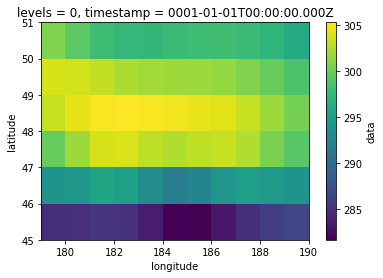

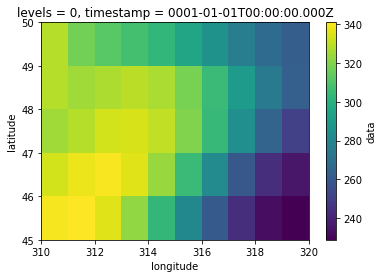

In [4]:
# plot the map for one timestep/level for each of the gridded products
for iaxr in regions_list_data_raw_xarray:
    print(iaxr)
    if iaxr:
        plt.figure()
        iaxr['data'][:,:,0].plot()

In [5]:
len(regions_list_data_horiz_ave)

4

In [6]:
cols = ['k','r','b','m']

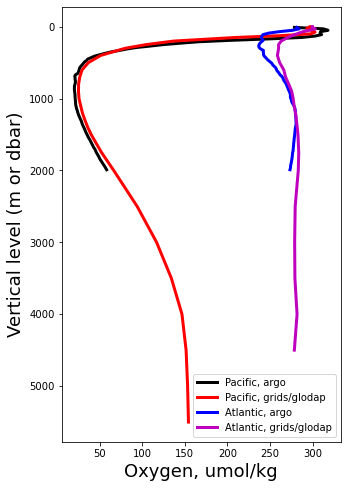

In [7]:
# plot the horizontal average for (vertically) interpolated profiles and for the gridded product
plt.figure(figsize=(5,8))
for i,idata in enumerate(regions_list_data_horiz_ave):
    plt.plot(idata,regions_list_data_horiz_ave_levels[i],color=cols[i],linewidth=3)
plt.gca().invert_yaxis()
plt.ylabel('Vertical level (m or dbar)',size=18)
plt.xlabel(vartitle,size=18)
plt.legend([a_+', '+b_ for a_, b_ in zip(regions_list_tags,regions_list_collections)])


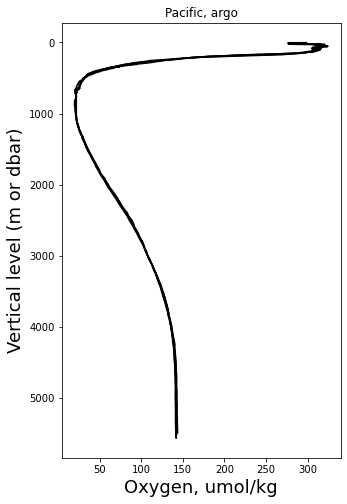

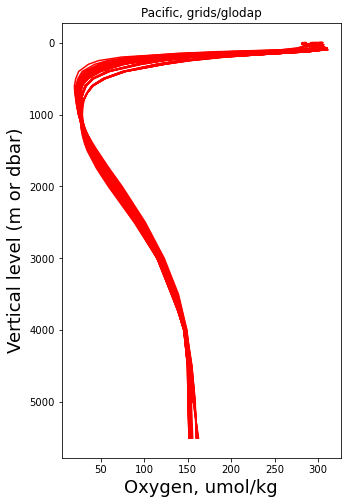

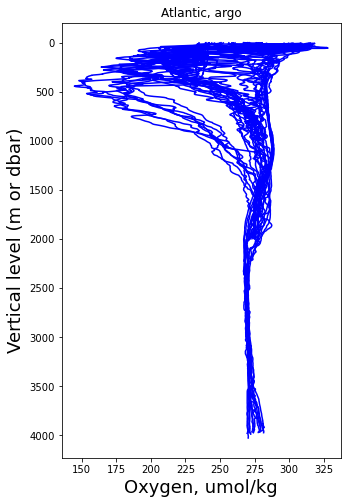

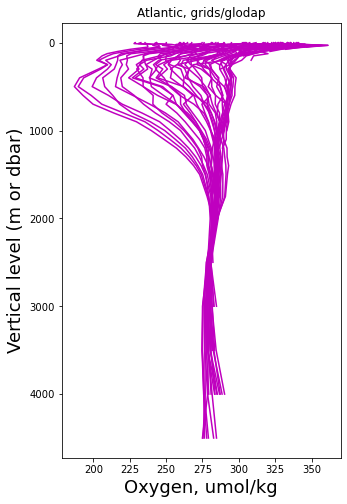

In [10]:
for i,idata in enumerate(regions_list_data_raw):
    plt.figure(figsize=(5,8))
    for iidata in idata:
        
        plt.plot(iidata[0],iidata[1],color=cols[i])
    plt.gca().invert_yaxis()
    plt.ylabel('Vertical level (m or dbar)',size=18)
    plt.xlabel(vartitle,size=18)
    plt.title(regions_list_tags[i]+', '+regions_list_collections[i])

In [ ]:
to continue from here

In [ ]:
# plot raw profiles that go into the average
for i,idata in enumerate(regions_list_data_noave_nointerp):
    for iidata in idata:
        
        plt.plot(iidata[0],iidata[1],color=cols[i]) #,marker='.'
        
        # check for oxygen data
        if ('doxy' in variable) and sum(np.array(iidata[0])<0) != 0:
            check_data
#plt.ylim([0, 20])
plt.gca().invert_yaxis()        
plt.ylabel('Vertical level')
plt.xlabel(variable_title)


In [ ]:
# plot vertically integrated profiles that go into the average
for i,idata in enumerate(regions_list_data_noave):
    for ii,iidata in enumerate(idata):
        
        plt.plot(iidata,regions_list_data_levels[i],color=cols[i])
        if sum(np.array(iidata)<0) != 0:
            ciao
plt.gca().invert_yaxis()

In [ ]:
#regions_list_data_time_month = [x.month for y in regions_list_data_time for x in y]
# plot raw profiles that go into the average colorcoded by month of year
for i,idata in enumerate(regions_list_data_noave_nointerp):
    itime = regions_list_data_time[i]
    for ii,iidata in enumerate(idata):
        
        if ii<=len(itime)-1 and itime[ii].month in [6, 7, 8]:
            plt.plot(iidata[0],iidata[1],c='k',marker='.')
            
        # check for oxygen data
        if ('doxy' in variable) and sum(np.array(iidata[0])<0) != 0:
            check_data
plt.ylim([0, 20])
plt.gca().invert_yaxis()        
plt.ylabel('Vertical level')
plt.xlabel(variable_title)